#### IMputation Techniques
>It is very common to have datasets with missing values. This notebook explores several options for dealing with missing data. I am using the breast cancer data set breast-cancer-wisconsin.data.txt from http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/ (description at http://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Original%29 ) which has missing values. I am planning on implementing the following techniques and then creating KNN and SVM models using the new datasets to compare how the different imputation techniques impacted the modesl.
>1. mean/mode imputation method to impute values for the missing data.
>2. regression to impute values for the missing data.
>3. regression with perturbation to impute values for the missing data.
>4. including a binary variable to indicate missing values. 

To tackle this problem I plan on taking the following steps:
1. Load and analyze the dataset
2. Create a new dataset using mean/mode imputation for missing values
3. Create a new dataset using regression to impute values
4. Create a new dataset using regression with perturbation to impute values
5. Create a new dataset with a binary variable to indicate missing values
6. Create a SVM and KNN model using the datasets created in 2,3, 4, and 5 as well as the original dataset without any of the missing values
8. Compare results of the various SVM and KNN models

First, I'll start by loading the necessary libraries, setting the seed, and making sure results are reset.

In [27]:
# Clear environment
rm(list = ls())

# Set seed so output is reproducible
set.seed(1)

# Load libraries needed for analysis
library(ggplot2) # Used for data visualization
library(dplyr) # Used for cleaning the data
library(outliers) # Used to check for outliers
library(DAAG) # for cross validation
library(cowplot) # for creating grid of plots
library(kknn) # for knn models
library(kernlab) # for SVM

#### Step 1 - Load and Analyze the Data

Next, I'll load and examine the data. Looking at the information about the dataset found at the UC Irvine Machine Learning Repository, we see that there are 699 datapoints taken from patients for Dr. Woldberg over the course of 1989 to 1991. The dataset has 1 ID, 9 features and one target variable which is used for classifying breast cancer as benign or malignant. The variable Bare_nuclei has the missing values and they are currently denoted by a '?'. The variables in the dataset are shown below:

<html>
    <div class="overflow-x-auto"><table class="my-4 table w-full"><thead><tr><th>Variable Name</th><th>Role</th><th>Type</th><th>Description</th><th>Units</th><th>Missing Values</th></tr></thead> <tbody><tr><td>Sample_code_number</td><td>ID</td><td>Categorical</td><td></td><td></td><td>no</td> </tr><tr><td>Clump_thickness</td><td>Feature</td><td>Integer</td><td></td><td></td><td>no</td> </tr><tr><td>Uniformity_of_cell_size</td><td>Feature</td><td>Integer</td><td></td><td></td><td>no</td> </tr><tr><td>Uniformity_of_cell_shape</td><td>Feature</td><td>Integer</td><td></td><td></td><td>no</td> </tr><tr><td>Marginal_adhesion</td><td>Feature</td><td>Integer</td><td></td><td></td><td>no</td> </tr><tr><td>Single_epithelial_cell_size</td><td>Feature</td><td>Integer</td><td></td><td></td><td>no</td> </tr><tr><td>Bare_nuclei</td><td>Feature</td><td>Integer</td><td></td><td></td><td>yes</td> </tr><tr><td>Bland_chromatin</td><td>Feature</td><td>Integer</td><td></td><td></td><td>no</td> </tr><tr><td>Normal_nucleoli</td><td>Feature</td><td>Integer</td><td></td><td></td><td>no</td> </tr><tr><td>Mitoses</td><td>Feature</td><td>Integer</td><td></td><td></td><td>no</td> </tr><tr><td>Class</td><td>Target</td><td>Binary</td><td>2 = benign, 4 = malignant</td><td></td><td>no</td> </tr></tbody></table></div>
</html>

In [2]:
# Load the data
cancer_data <- read.csv("breast-cancer-wisconsin.data.txt", header = FALSE)

# Visually inspect the dataset to make sure everything loaded correctly
head(cancer_data)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11
1000025,5,1,1,1,2,1,3,1,1,2
1002945,5,4,4,5,7,10,3,2,1,2
1015425,3,1,1,1,2,2,3,1,1,2
1016277,6,8,8,1,3,4,3,7,1,2
1017023,4,1,1,3,2,1,3,1,1,2
1017122,8,10,10,8,7,10,9,7,1,4


Next I want to rename the variables so they align to what they represent.

In [3]:
# Assign more meaningful variable names and update several values in the dataset (not necessary but it makes it easier for me to interpret)
# %>% is a pipe operator that allows several operations (rename and mutate) to occur
cancer_data <- cancer_data %>%
    mutate_all(~na_if(., "?")) %>%
    rename(code_number = V1,
         clump_thickness = V2,
         uniformity_cell_size = V3,
         uniformity_cell_shape = V4,
         marginal_adhesion = V5,
         single_epithelial_cell_size = V6,
         bare_nuclei = V7,
         bland_chromatin = V8,
         normal_nucleoli = V9,
         mitosis = V10,
         class = V11)

# print a summary of the updated data
summary(cancer_data)

  code_number       clump_thickness  uniformity_cell_size uniformity_cell_shape
 Min.   :   61634   Min.   : 1.000   Min.   : 1.000       Min.   : 1.000       
 1st Qu.:  870688   1st Qu.: 2.000   1st Qu.: 1.000       1st Qu.: 1.000       
 Median : 1171710   Median : 4.000   Median : 1.000       Median : 1.000       
 Mean   : 1071704   Mean   : 4.418   Mean   : 3.134       Mean   : 3.207       
 3rd Qu.: 1238298   3rd Qu.: 6.000   3rd Qu.: 5.000       3rd Qu.: 5.000       
 Max.   :13454352   Max.   :10.000   Max.   :10.000       Max.   :10.000       
                                                                               
 marginal_adhesion single_epithelial_cell_size  bare_nuclei  bland_chromatin 
 Min.   : 1.000    Min.   : 1.000              1      :402   Min.   : 1.000  
 1st Qu.: 1.000    1st Qu.: 2.000              10     :132   1st Qu.: 2.000  
 Median : 1.000    Median : 2.000              2      : 30   Median : 3.000  
 Mean   : 2.807    Mean   : 3.216              5

Since this is a new dataset I want to get some basic information about the data which I will do below.

In [4]:
# Output the data class for each column transposed
t(sapply(cancer_data, class))

code_number,clump_thickness,uniformity_cell_size,uniformity_cell_shape,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitosis,class
integer,integer,integer,integer,integer,integer,factor,integer,integer,integer,integer


In [5]:
# Output the range of all the integer values for each column as a table
t(sapply(cancer_data[,-7], range))

code_number,61634,13454352
clump_thickness,1,10
uniformity_cell_size,1,10
uniformity_cell_shape,1,10
marginal_adhesion,1,10
single_epithelial_cell_size,1,10
bland_chromatin,1,10
normal_nucleoli,1,10
mitosis,1,10
class,2,4


In [6]:
# Check for missing values
sapply(cancer_data, anyNA)

code_number             clump_thickness 
                      FALSE                       FALSE 
       uniformity_cell_size       uniformity_cell_shape 
                      FALSE                       FALSE 
          marginal_adhesion single_epithelial_cell_size 
                      FALSE                       FALSE 
                bare_nuclei             bland_chromatin 
                       TRUE                       FALSE 
            normal_nucleoli                     mitosis 
                      FALSE                       FALSE 
                      class 
                      FALSE

Now that I know that the bare_nuclei column contains missing values, I want to know where the missing values are and how many there are.

In [7]:
cat("Location of missing values in the bare_nuclei column")
missing_rows <- which(is.na(cancer_data$bare_nuclei))
t(missing_rows)
 
missing_count <- sum(is.na(cancer_data$bare_nuclei))
cat("Count of missing values in the bare_nuclei column", missing_count, "\n\n")


cat("Percentange of missing values is", (missing_count/nrow(cancer_data))*100,"%")

Location of missing values in the bare_nuclei column

24,41,140,146,159,165,236,250,276,293,295,298,316,322,412,618


Count of missing values in the bare_nuclei column 16 

Percentange of missing values is 2.288984 %

Since there is less than 5% of the data missing for the bare_nuclei factor we are good to imputation to clean the data. Next I want to inspect the datapoints where there are missing values.

In [8]:
# Show the observations with missing data.
na_subset <- cancer_data[which(is.na(cancer_data$bare_nuclei)),]
na_subset

,code_number,clump_thickness,uniformity_cell_size,uniformity_cell_shape,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitosis,class
24,1057013,8,4,5,1,2,NA,7,3,1,4
41,1096800,6,6,6,9,6,NA,7,8,1,2
140,1183246,1,1,1,1,1,NA,2,1,1,2
146,1184840,1,1,3,1,2,NA,2,1,1,2
159,1193683,1,1,2,1,3,NA,1,1,1,2
165,1197510,5,1,1,1,2,NA,3,1,1,2
236,1241232,3,1,4,1,2,NA,3,1,1,2
250,169356,3,1,1,1,2,NA,3,1,1,2
276,432809,3,1,3,1,2,NA,2,1,1,2
293,563649,8,8,8,1,2,NA,6,10,1,4


Looking at the data there isn't any obvious bias but I want to make sure so I'll compare the statistics for the overall dataset with the dataset of missing values to make sure they are approximatily the same.

In [9]:
# Custom labels for the summary statistics
labels <- c("Min", "1st Qu.", "Median", "Mean", "3rd Qu.", "Max")

# Loop through each column and print summary statistics side by side
for (col in names(cancer_data)) {
  if (col == "code_number" || col == "bare_nuclei") next
  cat("Column:", col, "\n")
  cat("Overall Dataset\t\tNA Rows Subset\n")
  cat(paste(labels, summary(cancer_data[[col]]), "\t", labels, summary(na_subset[[col]]), "\n"))
  cat("\n")
}

Column: clump_thickness 
Overall Dataset		NA Rows Subset
Min 1 	 Min 1 
 1st Qu. 2 	 1st Qu. 1 
 Median 4 	 Median 3 
 Mean 4.41773962804006 	 Mean 3.375 
 3rd Qu. 6 	 3rd Qu. 5 
 Max 10 	 Max 8 

Column: uniformity_cell_size 
Overall Dataset		NA Rows Subset
Min 1 	 Min 1 
 1st Qu. 1 	 1st Qu. 1 
 Median 1 	 Median 1 
 Mean 3.13447782546495 	 Mean 2.4375 
 3rd Qu. 5 	 3rd Qu. 4 
 Max 10 	 Max 8 

Column: uniformity_cell_shape 
Overall Dataset		NA Rows Subset
Min 1 	 Min 1 
 1st Qu. 1 	 1st Qu. 1 
 Median 1 	 Median 2.5 
 Mean 3.20743919885551 	 Mean 2.875 
 3rd Qu. 5 	 3rd Qu. 4.25 
 Max 10 	 Max 8 

Column: marginal_adhesion 
Overall Dataset		NA Rows Subset
Min 1 	 Min 1 
 1st Qu. 1 	 1st Qu. 1 
 Median 1 	 Median 1 
 Mean 2.8068669527897 	 Mean 1.8125 
 3rd Qu. 4 	 3rd Qu. 1 
 Max 10 	 Max 9 

Column: single_epithelial_cell_size 
Overall Dataset		NA Rows Subset
Min 1 	 Min 1 
 1st Qu. 2 	 1st Qu. 2 
 Median 2 	 Median 2 
 Mean 3.21602288984263 	 Mean 2.4375 
 3rd Qu. 4 	 3rd Qu. 2 
 

Looking at the results above, there does appear to be some bias towards smaller values in all the variables and less malignent classifications. It doesn't seem to be so far skewed that using imputation won't work but is worth noting. Now that I have a good sense of the data I am working with I'm ready to create new datasets using imputation to replace the missing values in bare_nuclei.

#### Step 2 - Mean/Mode Imputation
Since bare_nuclei column is an integer I am going to use the median value to replace all of the na values in the column. Using the mean is another option but would result in a float value which isn't consistent with the rest of the data. Calling the column a categorical variable and using the mode would result in the same thing.

In [10]:
# Create a new dataset
mm_cancer_data <- cancer_data

# Update the bare_nuclei column to be type numeric and calculate the median value
mm_cancer_data$bare_nuclei <- as.numeric(as.character(mm_cancer_data$bare_nuclei))
median_value <- median(mm_cancer_data$bare_nuclei, na.rm = TRUE)

# Replace the na values with the median
mm_cancer_data$bare_nuclei[is.na(mm_cancer_data$bare_nuclei)] <- median_value

# Get summary statistics for the new column
summary(mm_cancer_data$bare_nuclei)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   3.486   5.000  10.000 

#### Step 3 - Regression Imputation
Next up I am going to create a regression model to predict the values for the bare_nuclei missing values using all but the ID and class variables (response variable). I'll use stepwise regression to determine the variables to use for creating the model.

In [11]:
# Get the dataset
reduced_data <- cancer_data[-missing_rows, 2:10]
reduced_data$bare_nuclei <- as.numeric(as.character(reduced_data$bare_nuclei))

# Create base model
base_model <- lm(bare_nuclei ~ ., data = reduced_data)
summary(base_model)


Call:
lm(formula = bare_nuclei ~ ., data = reduced_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.7316 -0.9426 -0.3002  0.6725  8.6998 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 -0.616652   0.194975  -3.163  0.00163 ** 
clump_thickness              0.230156   0.041691   5.521 4.83e-08 ***
uniformity_cell_size        -0.067980   0.076170  -0.892  0.37246    
uniformity_cell_shape        0.340442   0.073420   4.637 4.25e-06 ***
marginal_adhesion            0.339705   0.045919   7.398 4.13e-13 ***
single_epithelial_cell_size  0.090392   0.062541   1.445  0.14883    
bland_chromatin              0.320577   0.059047   5.429 7.91e-08 ***
normal_nucleoli              0.007293   0.044486   0.164  0.86983    
mitosis                     -0.075230   0.059331  -1.268  0.20524    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.274 on 674 degrees of freedom
Multiple

There are several variables that are showing as insignificant, I'm going to use stepwise regression based on the BIC value to determine which variables to keep.

In [12]:
# Create model using stepwise regression based on BIC
sr_model <- step(base_model, direction="both", k=log(nrow(reduced_data)), trace=0)
summary(sr_model)


Call:
lm(formula = bare_nuclei ~ clump_thickness + uniformity_cell_shape + 
    marginal_adhesion + bland_chromatin, data = reduced_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.8115 -0.9531 -0.3111  0.6678  8.6889 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)           -0.53601    0.17514  -3.060   0.0023 ** 
clump_thickness        0.22617    0.04121   5.488 5.75e-08 ***
uniformity_cell_shape  0.31729    0.05086   6.239 7.76e-10 ***
marginal_adhesion      0.33227    0.04431   7.499 2.03e-13 ***
bland_chromatin        0.32378    0.05606   5.775 1.17e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.274 on 678 degrees of freedom
Multiple R-squared:  0.6129,	Adjusted R-squared:  0.6107 
F-statistic: 268.4 on 4 and 678 DF,  p-value: < 2.2e-16


Now I will create the new model based on the variables identified above and calculate the cross validated R-squared value for the model.

In [13]:
# Create the new model
model <- lm(bare_nuclei ~ clump_thickness + uniformity_cell_shape + marginal_adhesion + bland_chromatin, data = reduced_data)

# Cross validate the model
cv_model <- cv.lm(reduced_data, model, m=5, plotit = FALSE)

# Calculate the R-Squared value
TSS <- sum((reduced_data$bare_nuclei - mean(reduced_data$bare_nuclei))^2)
CV_Rsquared <- 1 - (attr(cv_model, "ms")*nrow(reduced_data))/TSS
cat("\n\n", "The models cross-validated R-Squared value is:", CV_Rsquared)

Analysis of Variance Table

Response: bare_nuclei
                       Df Sum Sq Mean Sq F value  Pr(>F)    
clump_thickness         1   3185    3185   616.2 < 2e-16 ***
uniformity_cell_shape   1   1683    1683   325.5 < 2e-16 ***
marginal_adhesion       1    510     510    98.6 < 2e-16 ***
bland_chromatin         1    172     172    33.4 1.2e-08 ***
Residuals             678   3505       5                    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


fold 1 
Observations in test set: 136 
                 4       6     12    21    22     29     36    37    51    55
Predicted    4.663 10.0184  1.213  6.62 6.575  1.213  1.213 10.15  5.02 7.572
cvpred       4.619 10.0582  1.255  6.52 6.465  1.255  1.255 10.07  4.82 7.447
bare_nuclei  4.000 10.0000  1.000 10.00 7.000  1.000  1.000  1.00  3.00 8.000
CV residual -0.619 -0.0582 -0.255  3.48 0.535 -0.255 -0.255 -9.07 -1.82 0.553
                56    57    59    64     67   74     80    81     82   87
Predicted   

This shows that our model does not do a great job at predicting the bare_nuclei value with a cross validated R-Squared value of 0.608. This would be a good reason to consider whether or not to use this as a imputation technique but I will move forward whith the assumption that it is good enough. The next step is to replace the missing values in the dataset with the predicted values from the regression model.

In [14]:
# Get predictions from our model and create dataframe of all the rows with missing values
bare_nuclei_hat <- predict(model, newdata = cancer_data[missing_rows,])
new_data <- cancer_data[missing_rows,]

# Make the bare_nuclei values integers to match the rest of the data
new_data$bare_nuclei <- as.integer(round(bare_nuclei_hat))
new_data

,code_number,clump_thickness,uniformity_cell_size,uniformity_cell_shape,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitosis,class
24,1057013,8,4,5,1,2,5,7,3,1,4
41,1096800,6,6,6,9,6,8,7,8,1,2
140,1183246,1,1,1,1,1,1,2,1,1,2
146,1184840,1,1,3,1,2,2,2,1,1,2
159,1193683,1,1,2,1,3,1,1,1,1,2
165,1197510,5,1,1,1,2,2,3,1,1,2
236,1241232,3,1,4,1,2,3,3,1,1,2
250,169356,3,1,1,1,2,2,3,1,1,2
276,432809,3,1,3,1,2,2,2,1,1,2
293,563649,8,8,8,1,2,6,6,10,1,4


Looking at the data above I can see that all of the values are within the expected range (1-10) and are all integers. Now I will add it to the rest of the data to complete the dataset.

In [15]:
# Update regression data to have all of the columns but not any of the rows with missing values
regression_data <- cancer_data[-missing_rows,]

# Make sure that the bare_nuclei column is an integer
regression_data$bare_nuclei <- as.integer(as.character(regression_data$bare_nuclei))

# Add the new data based on predictions
regression_data <- rbind(regression_data, new_data)

summary(regression_data)

  code_number       clump_thickness uniformity_cell_size uniformity_cell_shape
 Min.   :   61634   Min.   : 1.00   Min.   : 1.00        Min.   : 1.00        
 1st Qu.:  870688   1st Qu.: 2.00   1st Qu.: 1.00        1st Qu.: 1.00        
 Median : 1171710   Median : 4.00   Median : 1.00        Median : 1.00        
 Mean   : 1071704   Mean   : 4.42   Mean   : 3.13        Mean   : 3.21        
 3rd Qu.: 1238298   3rd Qu.: 6.00   3rd Qu.: 5.00        3rd Qu.: 5.00        
 Max.   :13454352   Max.   :10.00   Max.   :10.00        Max.   :10.00        
 marginal_adhesion single_epithelial_cell_size  bare_nuclei    bland_chromatin
 Min.   : 1.00     Min.   : 1.00               Min.   : 1.00   Min.   : 1.00  
 1st Qu.: 1.00     1st Qu.: 2.00               1st Qu.: 1.00   1st Qu.: 2.00  
 Median : 1.00     Median : 2.00               Median : 1.00   Median : 3.00  
 Mean   : 2.81     Mean   : 3.22               Mean   : 3.53   Mean   : 3.44  
 3rd Qu.: 4.00     3rd Qu.: 4.00               3rd Q

#### Step 4 - Regression with Perturbation Imputation
Since I already have the regression model and it's predictions I can use those predictions as the mean values and calculate the standard deviation to use for perturbation. I used the rnorm() function and found this article helpful in it's implementation: https://www.geeksforgeeks.org/a-guide-to-dnorm-pnorm-rnorm-and-qnorm-in-r/.

In [16]:
reg_pert <- rnorm(nrow(new_data), new_data$bare_nuclei, sd(new_data$bare_nuclei))
reg_pert

[1]  6.410  3.381  0.139 -0.303  0.977  3.052  1.163 -0.235  6.511  7.604
[11]  2.717  3.438  6.185  3.950 -0.640 -1.141

Some of the values are negative and below 1 which I will have to set to one since it it outside of the range for the bare nuclei variable in the dataset. I am also going to convert the values to integers and then create a new dataset with the imputed values using regression with perturbation.

In [17]:
# Make sure all of the values fall within the range of 1 and 10
reg_pert[reg_pert < 1] <- 1
reg_pert[reg_pert > 10] <- 10

# Create regression w/ perturbation data that has all of the columns but not any of the rows with missing values
reg_pert_data <- cancer_data

# Update the missing values with the new imputed values
reg_pert_data[missing_rows,]$bare_nuclei <- as.factor(as.integer(reg_pert))

# Make sure that the bare_nuclei column is an integer
reg_pert_data$bare_nuclei <- as.integer(as.character(reg_pert_data$bare_nuclei))

# Print out the data points with imputed values
reg_pert_data[missing_rows,]

,code_number,clump_thickness,uniformity_cell_size,uniformity_cell_shape,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitosis,class
24,1057013,8,4,5,1,2,6,7,3,1,4
41,1096800,6,6,6,9,6,3,7,8,1,2
140,1183246,1,1,1,1,1,1,2,1,1,2
146,1184840,1,1,3,1,2,1,2,1,1,2
159,1193683,1,1,2,1,3,1,1,1,1,2
165,1197510,5,1,1,1,2,3,3,1,1,2
236,1241232,3,1,4,1,2,1,3,1,1,2
250,169356,3,1,1,1,2,1,3,1,1,2
276,432809,3,1,3,1,2,6,2,1,1,2
293,563649,8,8,8,1,2,7,6,10,1,4


#### Step 5 - Add Binary Value to Indicate Missing Value
I found the discussion here: https://www.quora.com/What-is-the-binary-flag-addition-technique-in-statistics-and-how-is-it-used-in-data-imputation to be useful in understanding this approach. I am going to add an additional column 'indicator' so that if a particular record is not imputed then the value of the flag variable will be 0. 
If a particular record is imputed then the value of the flag variable will be  I am going to create an additional dataset for each of the datsets created above with imputed values with this indicator column.1.

In [18]:
# Mean/Mode Imputation
mm_indicator <- mm_cancer_data
mm_indicator$indicator <- 0
mm_indicator[missing_rows,]$indicator <- 1

# Regression Imputation
reg_indicator <- regression_data
reg_indicator$indicator <- 0
reg_indicator[missing_rows,]$indicator <- 1

# Regression with Perturbation Imputation
reg_pert_indicator <- reg_pert_data
reg_pert_indicator$indicator <- 0
reg_pert_indicator[missing_rows,]$indicator <- 1

Lastly, I want to visualize the distribution of the new datasets so I am going to plot histograms for each of the datasets created with imputation as well as the dataset with all the missing values removed.

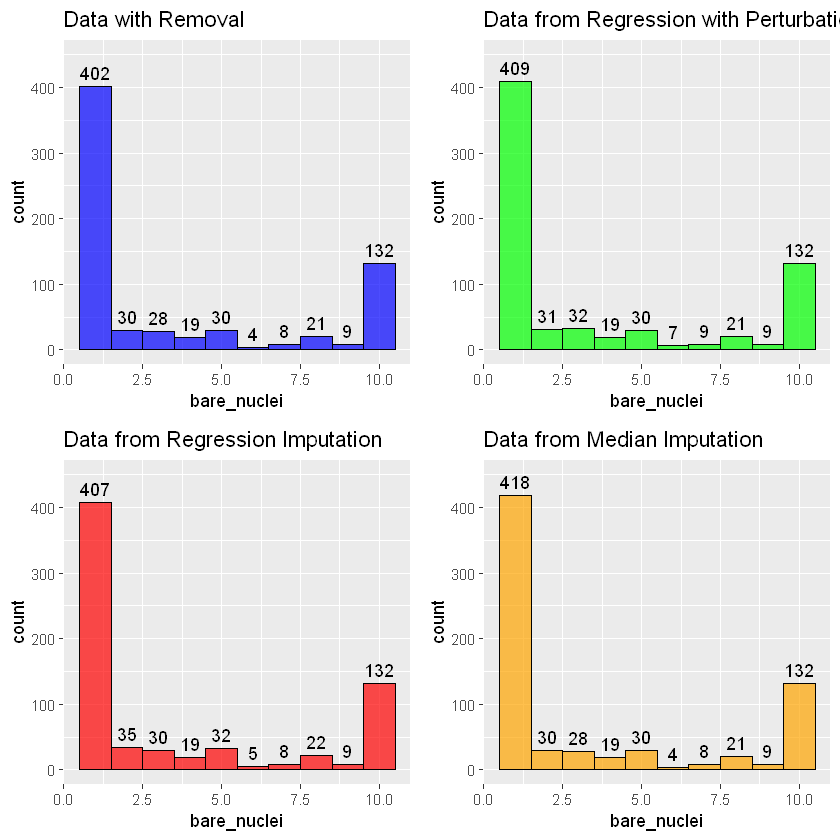

In [19]:
# Set up the layout for the multi-panel plot
par(mfrow = c(2, 2))

removed_data <- cancer_data[-missing_rows,]
removed_data$bare_nuclei <- as.integer(as.character(removed_data$bare_nuclei))

# Create histograms with ggplot
hist_removed <- ggplot(removed_data, aes(x = bare_nuclei)) +
  geom_histogram(binwidth = 1, fill = "blue", color = "black", alpha = 0.7) +
  labs(title = "Data with Removal") +
  geom_text(aes(label = paste(stat(count))), stat = "count", vjust = -0.5) +
  coord_cartesian(ylim = c(0, 450))

hist_reg_pert <- ggplot(reg_pert_data, aes(x = bare_nuclei)) +
  geom_histogram(binwidth = 1, fill = "green", color = "black", alpha = 0.7) +
  labs(title = "Data from Regression with Perturbation Imputation") +
  geom_text(aes(label = paste(stat(count))), stat = "count", vjust = -0.5) +
  coord_cartesian(ylim = c(0, 450))

hist_regression <- ggplot(regression_data, aes(x = bare_nuclei)) +
  geom_histogram(binwidth = 1, fill = "red", color = "black", alpha = 0.7) +
  labs(title = "Data from Regression Imputation") +
  geom_text(aes(label = paste(stat(count))), stat = "count", vjust = -0.5) +
  coord_cartesian(ylim = c(0, 450))

hist_mm_cancer <- ggplot(mm_cancer_data, aes(x = bare_nuclei)) +
  geom_histogram(binwidth = 1, fill = "orange", color = "black", alpha = 0.7) +
  labs(title = "Data from Median Imputation") +
  geom_text(aes(label = paste(stat(count))), stat = "count", vjust = -0.5) +
  coord_cartesian(ylim = c(0, 450))

# Combine histograms into a 2x2 grid
plot_grid(hist_removed, hist_reg_pert, hist_regression, hist_mm_cancer, ncol = 2)

The distributions haven't changed much visually which is good but all three imputation techniques does make the datasets slightly more right skewed. Now on to the models!

#### Step 6 - Create SVM and KNN Models'
Now that I have all the datasets prepared, I am going to create functions for creating a KNN and SVM model, run all of the datasets through the functions, and compare the results.

The first step I'm going to take is to determine the optimal k number for the KNN model. To do this I am going to iterate through the four base datasets (without indicator variable) and various k values to see what works best.

In [20]:
# K values to check
k_len = 10

# Create dataframe for storing results
knn_results_df <- data.frame('k_value' = numeric(), 'model' = character(), 'Accuracy' = numeric(), stringsAsFactors = FALSE)

# Model list to loop through
model_list <- list(removed_data = removed_data, regression_data = regression_data, reg_pert_data = reg_pert_data, mm_cancer_data = mm_cancer_data)

# Loop through each model, check the accuracry for each k value, and save to the dataframe
for (model_name in names(model_list)){
    model <- model_list[[model_name]]
    n_rows <- nrow(model)
    for (k_val in 1:k_len) {
        knn_prediction <- array(0, n_rows)
        for (i in 1:nrow(model)) {
            train_data <- model[-i,]
        	val_data <- model[i,]
        	knn_model = kknn(class~., train_data, val_data, k=k_val)
            x <- predict(knn_model)
            knn_prediction[i] <- ifelse(x < 3, 2, 4)
        }
        knn_accuracy <- 100 * sum(model$class == knn_prediction)/n_rows
        knn_results_df <- rbind(knn_results_df, data.frame('k_value' = k_val, 'model' = model_name, 'Accuracy' = knn_accuracy))
    }
}

In [21]:
knn_results_df

k_value,model,Accuracy
1,removed_data,95.6
2,removed_data,95.6
3,removed_data,95.6
4,removed_data,95.6
5,removed_data,96.5
6,removed_data,96.5
7,removed_data,96.5
8,removed_data,96.8
9,removed_data,96.8
10,removed_data,96.8


Looking at the results it doesn't seem like the k-value is making much of a difference. I am going to use a k-value of 5 and compute the accuracy for each of the various datasets. I'll save the results into a dataframe to compare later.

In [22]:
# Create dataframe for storing results
results_df <- data.frame('Model' = character(), 'Dataset' = character(), 'Accuracy' = numeric(), stringsAsFactors = FALSE)

# Model list to loop through
dataset_list <- list(removed_data = removed_data, regression_data = regression_data, 
                   reg_pert_data = reg_pert_data, mm_cancer_data = mm_cancer_data,
                   mm_indicator = mm_indicator, reg_indicator = reg_indicator, 
                   reg_pert_indicator = reg_pert_indicator)

# Loop through each model, check the accuracry for each k value, and save to the dataframe
for (data_name in names(dataset_list)){
    data <- dataset_list[[data_name]]
    n_rows <- nrow(data)
    knn_prediction <- array(0, n_rows)
    for (i in 1:n_rows) {
        train_data <- data[-i,]
        val_data <- data[i,]
        knn_model = kknn(class~., train_data, val_data, k=5)
        x <- predict(knn_model)
        knn_prediction[i] <- ifelse(x < 3, 2, 4)
    }
    knn_accuracy <- 100 * sum(data$class == knn_prediction)/n_rows
    results_df <- rbind(results_df, data.frame('Model' = 'KNN', 'Dataset' = data_name, 'Accuracy' = knn_accuracy))
}

Next I want to create an SVM  model for each dataset, calculate it's accuracy, and add the results to the results_df. Just like for the KNN model I am going to start by trying to determine the optimal c-value for the SVM model.

In [23]:
C_values <- C_values <- c(.000000001, .00000001, .0000001, .000001, .00001, .0001, .001, .01, .1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000)
C_Value_df <- data.frame('C_Value' = numeric(), 'Dataset' = character(), 'Accuracy' = numeric(), stringsAsFactors = FALSE)
for (data_name in names(dataset_list)) {
    data <- dataset_list[[data_name]]
    n_rows <- nrow(data)
    for (C_val in C_values) {
    	vsm_model <- ksvm(as.matrix(data[,2:10]),as.factor(data[,11]),type="C-svc",kernel="vanilladot",C=C_val)
    	pred <- predict(vsm_model,data[,2:10])
    	accuracy <- 100 * sum(data$class == pred)/n_rows
        C_Value_df <- rbind(C_Value_df, data.frame(C_Value = C_val, Dataset = data_name, Accuracy = accuracy))
    }
}

 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 

In [24]:
C_Value_df[C_Value_df$Accuracy > 95, ]

,C_Value,Dataset,Accuracy
7,1e-03,removed_data,95.6
8,1e-02,removed_data,97.1
9,1e-01,removed_data,97.2
10,1e+00,removed_data,97.2
11,1e+01,removed_data,97.4
12,1e+02,removed_data,97.4
13,1e+03,removed_data,97.4
14,1e+04,removed_data,97.4
15,1e+05,removed_data,97.4
16,1e+06,removed_data,96.3


Looking at the results above (only printed high values because it was large), a C-value of 0.1 to 100,000 seems to work the best. I am going to use a C-Value of 10. Now that I have the c-value I will calculate the accuracy for each dataset using a training and testing dataset.

In [25]:
for (data_name in names(dataset_list)) {
    data <- dataset_list[[data_name]]
    n_rows <- nrow(data)
    SVM_prediction <- array(0, n_rows)
    for (i in 1:n_rows) {
        train_data <- data[-i,]
        svm_model <- ksvm(as.matrix(train_data[,2:10]),as.factor(train_data[,11]),type="C-svc",kernel="vanilladot",C=10)
        x <- predict(svm_model, data[i, 2:10])
        SVM_prediction[i] <- as.integer(as.character(x))
    }
    svm_accuracy <- 100 * sum(data$class == SVM_prediction)/n_rows
    results_df <- rbind(results_df, data.frame('Model' = 'SVM', 'Dataset' = data_name, 'Accuracy' = svm_accuracy))
}

 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 

#### Compare results of the various SVM and KNN models
Now that all the models have been created and the Accuracy for each model calculated I want to compare the results.

In [26]:
results_df

Model,Dataset,Accuracy
KNN,removed_data,96.5
KNN,regression_data,96.3
KNN,reg_pert_data,96.3
KNN,mm_cancer_data,96.4
KNN,mm_indicator,96.3
KNN,reg_indicator,96.1
KNN,reg_pert_indicator,96.3
SVM,removed_data,96.8
SVM,regression_data,96.7
SVM,reg_pert_data,96.6


Looking at the results above, **there isn't a clear difference in accuracy for the different datasets.** At least for this dataset, the imputation techniques used didn't make a big difference.